In [41]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Introduction:

DataSet: https://www.kaggle.com/uciml/pima-indians-diabetes-database

The goal of this project is to develop a Machine Learning model capable of predicting if a woman has diabetes, with some parameters, such as glucose in the last blood exam or insulin. This model will be a classifier and it will be tested through some different alternatives to check which one has the best outcome. 

Dependent variable: Outcome

Examples of Independent Variables: Life expectancy and Poverty rates

In [3]:
diabetes = pd.read_csv('diabetes.csv')

diabetes

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


# First look at the database

In [4]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


We can learn through the info function that there are no null values in the database, therefore we don't need to address any solution to the missing values

In [5]:
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


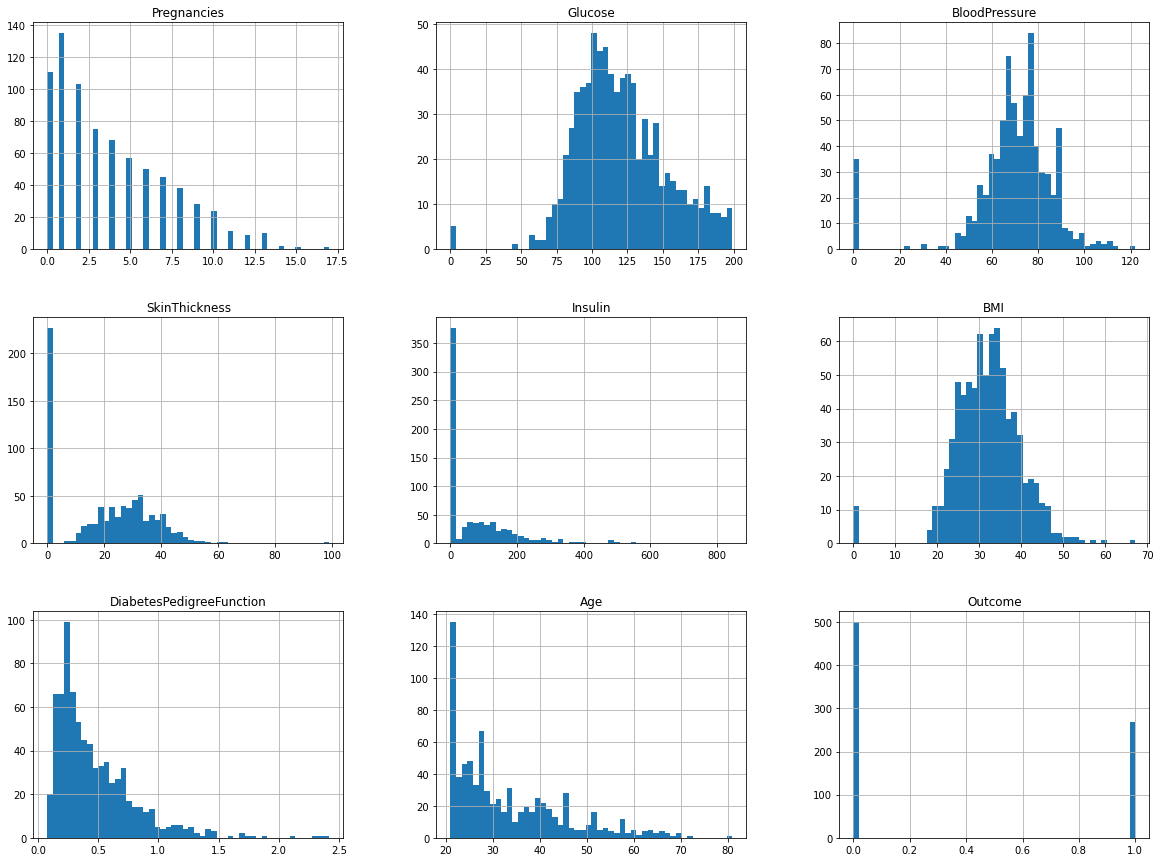

In [6]:
diabetes.hist(bins=50, figsize=(20, 15))
plt.show()

### Missing Values

As we can see, the dabatabase don't have null values, but, there are multiple 0s. This would make sense in some cases, such as pregnancies, but in others, for example, inslulin and blood pressure. This situations needs to be addressed. The approach we'll take will be by replacing the mean values of the whole column to the missing value. 

# Dividing in Train Test

We will be making the division of the train and test set stratifically. This is due to the fact that the parameter "Diabetes Pedigree Function" is believed to have a huge impact on the outcome, therefore, we believe that the train and the test sets should have the same proportion. Also, as we have a small amount of samples (m = 768) this type of separation can be usefull since, if we were to not to use it, the proportion would be unequal.

In [24]:
diabetes['pedigree_cat'] = np.ceil(diabetes['DiabetesPedigreeFunction'] / 0.18)
diabetes['pedigree_cat'].where(diabetes['pedigree_cat'] < 5, 5.0, inplace=True) 
diabetes['pedigree_cat'].value_counts(True)

2.0    0.356771
3.0    0.191406
5.0    0.175781
4.0    0.149740
1.0    0.126302
Name: pedigree_cat, dtype: float64

In [25]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(
    n_splits=1,
    test_size=0.2,
    random_state=RANDOM_SEED,
)
for train_index, test_index in split.split(diabetes, diabetes['pedigree_cat']):
    strat_train_set = diabetes.loc[train_index]
    strat_test_set = diabetes.loc[test_index]

In [33]:
print(strat_train_set['pedigree_cat'].value_counts(True), '\n', strat_test_set['pedigree_cat'].value_counts(True))

2.0    0.356678
3.0    0.190554
5.0    0.175896
4.0    0.149837
1.0    0.127036
Name: pedigree_cat, dtype: float64 
 2.0    0.357143
3.0    0.194805
5.0    0.175325
4.0    0.149351
1.0    0.123377
Name: pedigree_cat, dtype: float64


As we can see, both test and train has the same proportions of values.

In [34]:
#Now we need to drop the created column
strat_train_set.drop(['pedigree_cat'], axis=1, inplace=True)
strat_test_set.drop(['pedigree_cat'], axis=1, inplace=True)

# Exploratory analysis

In [35]:
diabetes_train = strat_train_set.copy()

<AxesSubplot:>

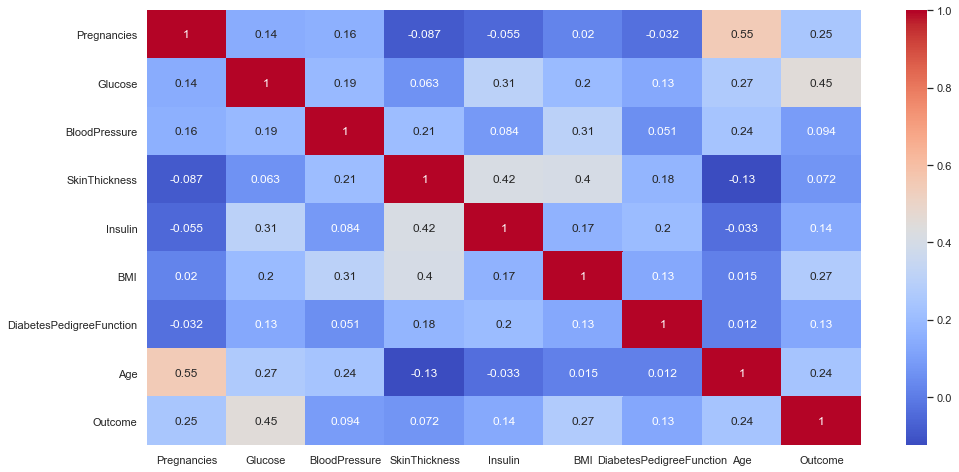

In [42]:
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")
corr = diabetes_train.corr()
sns.heatmap(corr,annot=True,cmap="coolwarm")